In [1]:
import numpy as np
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt
import datetime

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [14]:
# Load Train dataset
df = pd.read_excel("../data/_btt_sales_portfoy_prev.xlsx")

df = reduce_mem_usage(df)
df.head(5).append(df.tail(5))
df = df[df["portfoy"] == 1].reset_index(drop=True)

Mem. usage decreased to  1.80 Mb (62.5% reduction)


In [15]:
def peak_sigma(csv, kategori, sigma):
    demand = csv.copy()
    df=demand[demand['kategori_adi']==kategori].reset_index(drop=True)
    points=np.array(df['adet'])
    
    mean = np.mean(points, axis=0)
    std = np.std(points, axis=0)
       
    peaks=[]
    index=[]
    for idx,point in enumerate(points):
        point=points[idx]
    for i in range(idx+1):
        if  ((points[i]>=(sigma*std+mean)) or (points[i]<=(mean-sigma*std))):  
            peaks.append(points[i])
            index.append(i)
            
    fig, ax = plt.subplots(figsize=(20,10))
    plt.plot(df['date'], df['adet'], label=kategori)
    plt.plot(df['date'], [mean]*len(df['date']), label='data_mean')
    plt.legend(loc="upper left")
    plt.plot(df['date'][index], peaks, "o", c='r')
    ax.set_xticks(df['date'])
    ax.set_xticklabels(df['date'], rotation=90)
    plt.title("Peak Sigma")
    plt.grid()
    plt.show() ##-------------> Grafikleri görmek için plt.show() , kapatmak için plt.close() a çevirin
    
    special_dates=pd.DataFrame(df['date'][index]).reset_index(drop=True) 
    
    return (special_dates)


In [21]:
def deep_detection(data, sigma):
    demand = data.copy()
    demand_non_portfoy = demand[demand["portfoy"] == 0]
    demand = demand[demand["portfoy"] == 1]

    grup = demand["grup_adi"].unique()
    urun = demand["en_guncel_kod"].unique()
    for grp in grup:
        for sku in urun:
            df=demand[(demand['en_guncel_kod']==sku) & 
                      (demand["grup_adi"] == grp)]
            points=df['adet']

            mean = points.mean()
            std = points.std()

            peaks=[]
            index=[]
            for idx in points.index:
                if (points[idx]<=(mean-sigma*std)):
                    index.append(idx)

            for idx_ in sorted(index, reverse=True):
                demand.loc[idx_-1, "adet"] += demand.loc[idx_, "adet"] 
                demand.loc[idx_, "adet"] = 1
    demand = pd.concat([demand, demand_non_portfoy], axis=0)
    demand.sort_index(inplace=True)
    return demand

In [30]:
def peak_detection(data, sigma):
    demand = data.copy()
    demand["peak"] = 0
    demand_non_portfoy = demand[demand["portfoy"] == 0]
    demand = demand[demand["portfoy"] == 1]

    grup = demand["grup_adi"].unique()
    urun = demand["en_guncel_kod"].unique()
    for grp in grup:
        for sku in urun:
            df=demand[(demand['en_guncel_kod']==sku) & 
                      (demand["grup_adi"] == grp)]
            points=df['adet']

            mean = points.mean()
            std = points.std()

            peaks=[]
            index=[]
            for idx in points.index:
                if points[idx]>=(sigma*std+mean):
                    index.append(idx)

            for idx_ in index:
                demand.loc[idx_, "peak"] = 1
    demand = pd.concat([demand, demand_non_portfoy], axis=0)
    demand.sort_index(inplace=True)
    return demand

### Moving Average

In [23]:
def peak_mav(csv, period, kategori, sigma):
    demand = csv.copy()
    df=demand[demand['kategori_adi']==kategori].reset_index(drop=True)
    points=np.array(df['adet'])   
    
    mav_mean=df.adet.rolling(period, min_periods=1).mean()
    mav_std=df.adet.rolling(period, min_periods=1).std()
    
    peaks=[]
    index=[]
    for idx,point in enumerate(points):
        point=points[idx]
    for i in range(idx+1):
        if (points[i]>(sigma*mav_std[i]+mav_mean[i]) or  points[i]<(mav_mean[i]-sigma*mav_std[i])):
            peaks.append(points[i])
            index.append(i)
            
    fig, ax = plt.subplots(figsize=(20,10))
    plt.plot(df['date'], df['adet'], label=kategori)
    plt.plot(df['date'], mav_mean, label='moving_avg_mean')
    plt.legend(loc="upper left")
    plt.plot(df['date'][index], peaks, "o", c='r')
    ax.set_xticks(df['date'])
    ax.set_xticklabels(df['date'], rotation=90)
    plt.title("Peak Moving Average")
    plt.grid()
    plt.show()##-------------> Grafikleri görmek için plt.show() kapatmak için plt.close() a çevirin
    
    special_dates=pd.DataFrame(df['date'][index]).reset_index(drop=True) 
    
    return special_dates

---
# A101
---

In [24]:
df[(df["adet"] > 1) & (df["adet"] <= 1000)][["grup_adi", "en_guncel_kod"]].drop_duplicates()

,grup_adi,en_guncel_kod
463,BTT,55008
1545,BTT,142405
1854,BTT,40405


In [25]:
df_graph = df[(df["grup_adi"] == "BTT") & (df["en_guncel_kod"] == 55008)]

In [26]:
df_graph.iloc[:, :15]

,yil,ay,grup_adi,ana_kategori_adi,kategori_adi,marka_adi,urun_adi,en_guncel_kod,koli_i̇ci_adet,koli,kg,tl,adet,date,portfoy
435,2016,1,BTT,ATIŞTIRMALIK,ŞEKER,BONBON,"ULK BONBON LİMONLU RULO ŞEK.32,5Gx24x12",55008,288,108.000000,1010.880005,11508.480469,31104.000000,2016-01-01,1
436,2016,2,BTT,ATIŞTIRMALIK,ŞEKER,BONBON,"ULK BONBON LİMONLU RULO ŞEK.32,5Gx24x12",55008,288,41.000000,383.760010,4368.959961,11808.000000,2016-02-01,1
437,2016,3,BTT,ATIŞTIRMALIK,ŞEKER,BONBON,"ULK BONBON LİMONLU RULO ŞEK.32,5Gx24x12",55008,288,87.000000,814.320007,9270.719727,25056.000000,2016-03-01,1
438,2016,4,BTT,ATIŞTIRMALIK,ŞEKER,BONBON,"ULK BONBON LİMONLU RULO ŞEK.32,5Gx24x12",55008,288,124.000000,1160.640015,13213.440430,35712.000000,2016-04-01,1
439,2016,5,BTT,ATIŞTIRMALIK,ŞEKER,BONBON,"ULK BONBON LİMONLU RULO ŞEK.32,5Gx24x12",55008,288,189.000000,1769.040039,20139.839844,54432.000000,2016-05-01,1
440,2016,6,BTT,ATIŞTIRMALIK,ŞEKER,BONBON,"ULK BONBON LİMONLU RULO ŞEK.32,5Gx24x12",55008,288,86.000000,804.960022,9164.160156,24768.000000,2016-06-01,1
441,2016,7,BTT,ATIŞTIRMALIK,ŞEKER,BONBON,"ULK BONBON LİMONLU RULO ŞEK.32,5Gx24x12",55008,288,70.000000,655.200012,7459.200195,20160.000000,2016-07-01,1
442,2016,8,BTT,ATIŞTIRMALIK,ŞEKER,BONBON,"ULK BONBON LİMONLU RULO ŞEK.32,5Gx24x12",55008,288,78.000000,730.080017,8311.679688,22464.000000,2016-08-01,1
443,2016,9,BTT,ATIŞTIRMALIK,ŞEKER,BONBON,"ULK BONBON LİMONLU RULO ŞEK.32,5Gx24x12",55008,288,51.000000,477.359985,5434.560059,14688.000000,2016-09-01,1
444,2016,10,BTT,ATIŞTIRMALIK,ŞEKER,BONBON,"ULK BONBON LİMONLU RULO ŞEK.32,5Gx24x12",55008,288,131.000000,1226.160034,13959.360352,37728.000000,2016-10-01,1


In [32]:
check = peak_detection(df_graph, 1.0)

In [33]:
check[check["peak"] == 1]

,yil,ay,grup_adi,ana_kategori_adi,kategori_adi,marka_adi,urun_adi,en_guncel_kod,koli_i̇ci_adet,koli,...,lockdown,satis_var,fiyat,fiyat_gecisi,ciro_kull_i̇ade_dus,promosyon_tutari,iskonto__,enflasyon_etkisi,yarisma,peak
439,2016,5,BTT,ATIŞTIRMALIK,ŞEKER,BONBON,"ULK BONBON LİMONLU RULO ŞEK.32,5Gx24x12",55008,288,189.0,...,0,1,106.5625,0.0,852.47998,39.448502,0.046265,6.578125,0,1
447,2017,1,BTT,ATIŞTIRMALIK,ŞEKER,BONBON,"ULK BONBON LİMONLU RULO ŞEK.32,5Gx24x12",55008,288,191.0,...,0,1,106.5625,0.0,NaN,NaN,NaN,9.218750,0,1
451,2017,5,BTT,ATIŞTIRMALIK,ŞEKER,BONBON,"ULK BONBON LİMONLU RULO ŞEK.32,5Gx24x12",55008,288,334.0,...,0,1,106.5625,0.0,NaN,NaN,NaN,11.718750,0,1


In [27]:
def graph(kategori):
    sigma = peak_sigma(df_graph,kategori, 1.0)
    mav = peak_mav(df_graph, 6, kategori, 1.0)
    mav_all = peak_mav(df_graph, len(df_graph), kategori, 1.0)

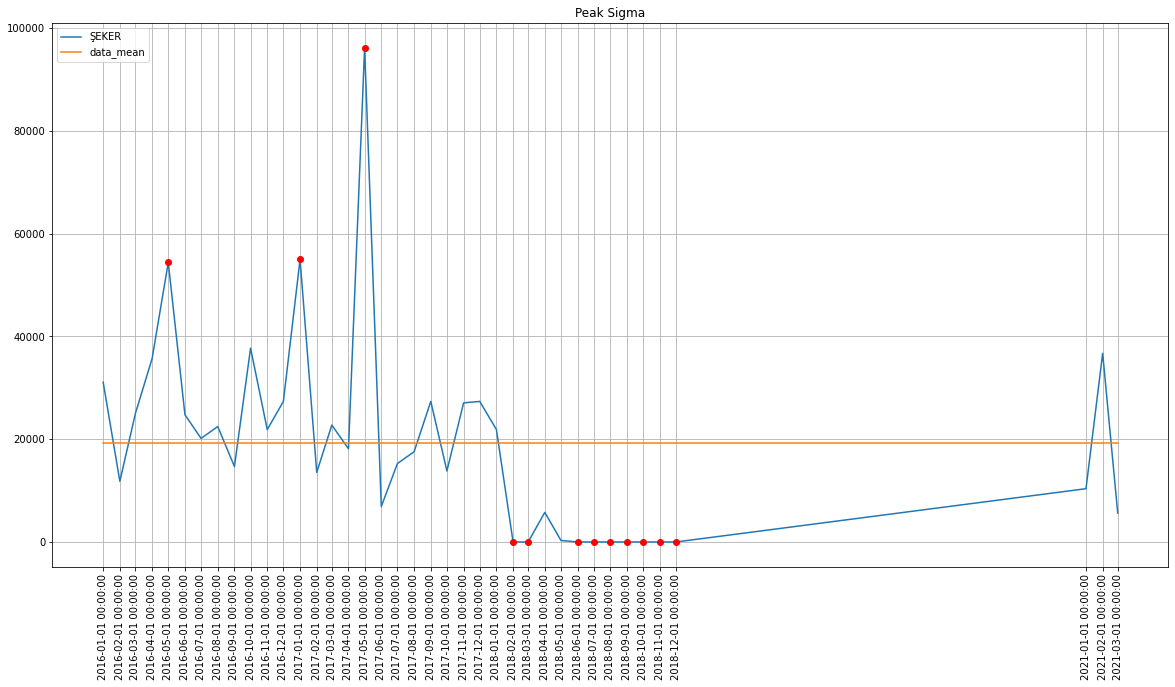

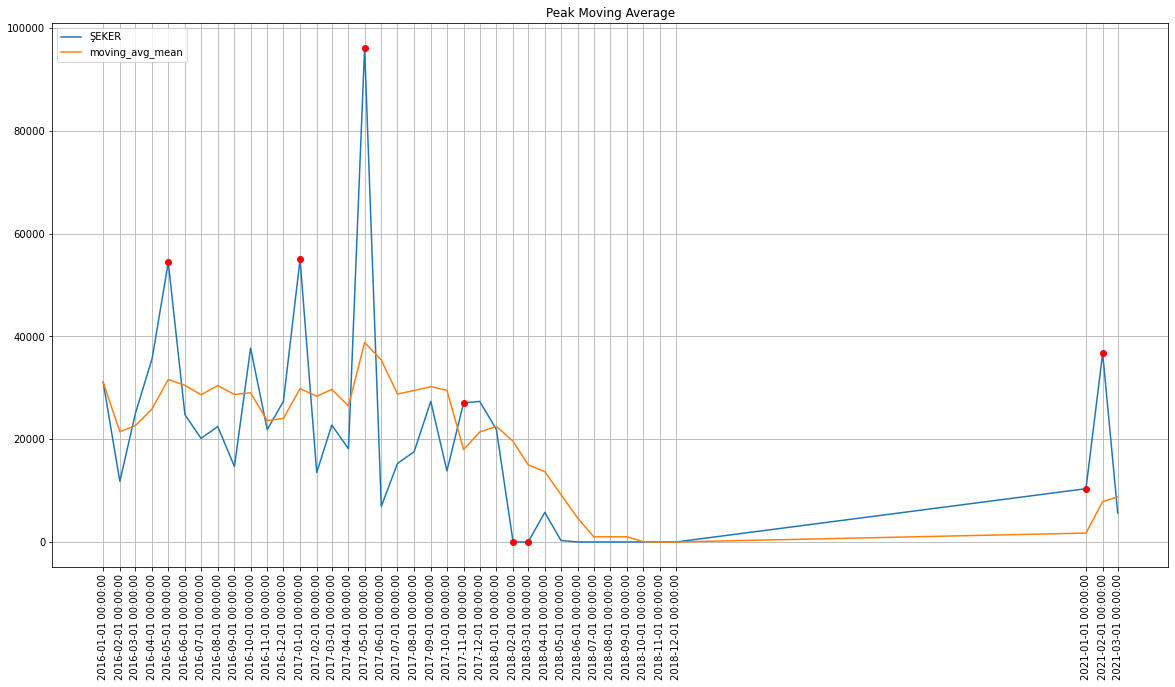

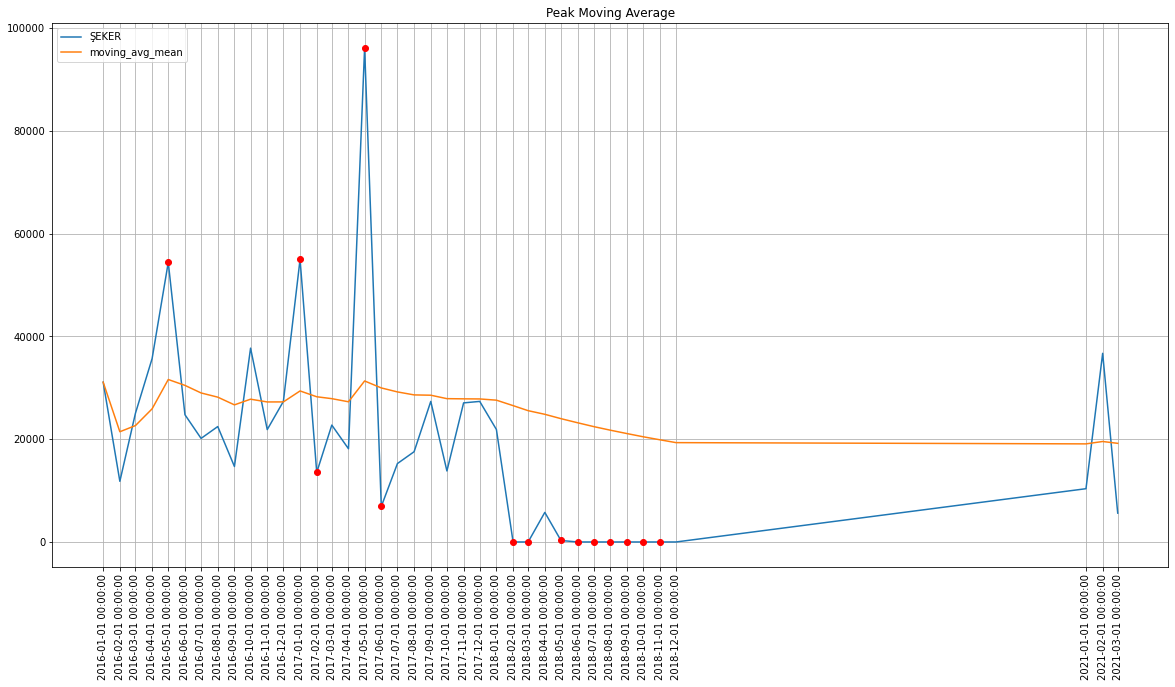

In [34]:
graph(df_graph["kategori_adi"].unique()[0])